# Run REopt API located on localhost or NREL server

## Initialization

In [1]:
%matplotlib widget
#%cd ..
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import copy
import os
from src.post_and_poll import get_api_results

In [2]:
# following is not necessary but silences warnings:
# InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.nrel.gov'. Adding certificate verification is strongly advised.
import urllib3
urllib3.disable_warnings()

## Load a previously saved API response .json file instead of running REopt

In [2]:
response_json = 'response_1'
with open('responses/' + response_json + '.json', 'rb') as handle:
    api_response = json.load(handle)

## Scenario Inputs (Post), if wanting to do a new API call

In [3]:
post_1 = {
  "Scenario": {
    "timeout_seconds": 400,
    "optimality_tolerance_bau": 0.05,
    "optimality_tolerance_techs": 0.05,
    "time_steps_per_hour": 1,
    "off_grid_flag": True,
    "Site": {
      "latitude": 37.78,
      "longitude": -122.45,
      "LoadProfile": {
        "doe_reference_name": "Hospital",
      },  
      "ElectricTariff": {
        "net_metering_limit_kw": 0.0,
        "interconnection_limit_kw": 100000000.0,
        "urdb_label": "5e1676e95457a3f87673e3b0"
      }
    }
  }
}

## Save the post to a .json file for sharing or future loading in

In [13]:
# Convert python dictionary post into json and save to a .json file
post_save = post_1
with open("posts/" + 'post_1.json', 'w') as fp:
    json.dump(post_save, fp)

## Or load in a saved .json file for the post

In [11]:
# Load a json into a python dictionary
load_post = "massproducer_offgrid"
with open("posts/" + load_post + ".json", 'r') as fp:
    post_1 = json.load(fp)

### Enter the root_url based on the "location" of the server that's hosting the API
### and your API key from developer.nrel.gov

In [4]:
# Enter the branch name here, only used for development/TestRanch and staging servers
branch_name = "offgrid-electrolyzer"

# Your API Key, only needed for production server
API_KEY = "uaz52dr5KTT5Qs5U72rS70hw3IYeHVEyAaDUFQvo"

# Local host, DO NOT use the first one if hosting API on Docker
#root_url = "http://localhost:8000/v1"  # Cannot access host localhost from "within Docker container" as this is configured
#root_url = "http://host.docker.internal:8000/v1"  # Must use this or below (gateway.docker.internal) for accessing host localhost
root_url = "http://gateway.docker.internal:8000/v1"  # This one **might** work for both linux and Windows - how about WSL2?

# Development/TestRanch server
#root_url = "https://" + branch_name + "-reopt-dev-api.its.nrel.gov/v1"

# Staging server
#root_url = "https://" + branch_name + "-reopt-stage-api.its.nrel.gov/v1"

# Production server
#root_url = "https://developer.nrel.gov/api/reopt/v1"

## POST and poll (period GET request) API to get a new result, if not loading in a previous response
## ...This may take a while!

In [12]:
api_response = get_api_results(post=post_1, 
                               API_KEY=API_KEY, 
                               api_url=root_url, 
                               results_file='responses/results.json', 
                               run_id=None)

main         INFO     Response OK from http://gateway.docker.internal:8000/v1/job/?api_key=uaz52dr5KTT5Qs5U72rS70hw3IYeHVEyAaDUFQvo.
main         INFO     Polling http://gateway.docker.internal:8000/v1/job/b396b375-6e00-4a03-994f-36d315b4cbd5/results/?api_key=uaz52dr5KTT5Qs5U72rS70hw3IYeHVEyAaDUFQvo for results with interval of 5s...
main         INFO     Saved results to responses/results.json


### If you get disconnected from the polling function but you think it ran, 
### copy the run_uuid from the log above to manually GET the results:

In [10]:
run_uuid = "10816148-36c0-4694-a96b-906416c0cc22"
results_url = root_url + '/v1/job/' + run_uuid + '/results/?api_key=' + API_KEY
resp = requests.get(url=results_url, verify=False)
api_response = json.loads(resp.text)

## Get summary of results

In [13]:
print("NPV ($) = ", api_response["outputs"]["Scenario"]["Site"]["Financial"]["npv_us_dollars"])
print("Capital Cost, Net ($) = ", api_response["outputs"]["Scenario"]["Site"]["Financial"]["net_capital_costs"])
tech_list = ["PV", "Wind", "Storage", "CHP", "Generator", "HotTES", "ColdTES", "AbsorptionChiller", "GHP", "NewBoiler", "SteamTurbine", "MassProducer"]
for tech in tech_list:
    if tech in post_1["Scenario"]["Site"].keys():
        if tech == "GHP":
            print("GHX Number of Boreholes = ", api_response["outputs"]["Scenario"]["Site"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
            print("GHP Heat Pump Capacity (ton) = ", api_response["outputs"]["Scenario"]["Site"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
        # PV and Storage are considered if the POST does not explicitly make max_[size] == 0
        if tech == "PV" and post_1["Scenario"]["Site"]["PV"]["max_kw"] == 0:
            pass
        elif tech == "Storage" and (post_1["Scenario"]["Site"]["Storage"]["max_kw"] == 0 or post_1["Scenario"]["Site"]["Storage"]["max_kwh"] == 0):
            pass
        else:
            for size_name_value in [(key, val) for key, val in api_response["outputs"]["Scenario"]["Site"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])
    elif tech in ["PV", "Storage", "Generator"]:
        for size_name_value in [(key, val) for key, val in api_response["outputs"]["Scenario"]["Site"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])

NPV ($) =  -12527331.0
Capital Cost, Net ($) =  7372418.5
PV size_kw  =  4079.4234
Storage size_kw  =  1016.4466092863067
Storage size_kwh  =  2846.5493443210207
Generator size_kw  =  797.5180833958361
MassProducer size_mass_per_time  =  10.0


In [15]:
api_response["outputs"]["Scenario"]["Site"]["MassProducer"]["year_one_electric_consumption_kwh"]

1978676.875

## Do some custom response/results data processing

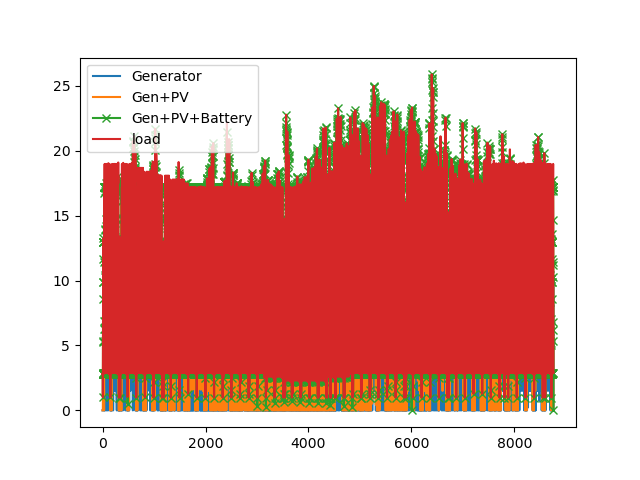

In [8]:
gen_to_load = api_response["outputs"]["Scenario"]["Site"]["Generator"]["year_one_to_load_series_kw"]
gen_to_battery = api_response["outputs"]["Scenario"]["Site"]["Generator"]["year_one_to_battery_series_kw"] 
pv_to_load = api_response["outputs"]["Scenario"]["Site"]["PV"]["year_one_to_load_series_kw"]
pv_to_battery = api_response["outputs"]["Scenario"]["Site"]["PV"]["year_one_to_battery_series_kw"]
pv_to_curtail = api_response["outputs"]["Scenario"]["Site"]["PV"]["year_one_curtailed_production_series_kw"]
battery_to_load = api_response["outputs"]["Scenario"]["Site"]["Storage"]["year_one_to_load_series_kw"]
load = api_response["outputs"]["Scenario"]["Site"]["LoadProfile"]["critical_load_series_kw"]

plt.clf()
plt.plot(gen_to_load, label="Generator")
plt.plot([gen_to_load[i] + pv_to_load[i] for i in range(len(pv_to_load))], label="Gen+PV")
plt.plot([gen_to_load[i] + pv_to_load[i] + battery_to_load[i] for i in range(len(pv_to_load))], label="Gen+PV+Battery", marker="x")
plt.plot(load, label="load")
plt.legend()
plt.show()

## Save API response and scenario data into a .pickle file for later use

In [27]:
response_save = api_response
file_name_to_save = "response_1"
with open("saved_responses/" + file_name_to_save + ".json", 'w') as fp:
    json.dump(response_save, fp)